In [1]:
import torch
import torch.nn as nn
import requests
import io
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class QAModel(nn.Module):
    def __init__(self, transformer_model_name="DeepPavlov/rubert-base-cased"):
        super(QAModel, self).__init__()

        self.transformer = AutoModel.from_pretrained(transformer_model_name)

        hidden_size = self.transformer.config.hidden_size
        self.start_vector = nn.Linear(hidden_size, 1)
        self.end_vector = nn.Linear(hidden_size, 1)

        self.classifier = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = transformer_output.last_hidden_state

        # Воспользуемся токеном начала последовательности для классификации
        has_answer = torch.sigmoid(self.classifier(hidden_states[:, 0, :])).squeeze(-1)

        start_logits = self.start_vector(hidden_states).squeeze(-1)

        start_pred = torch.argmax(start_logits, dim=-1)

        # Маскируем на всякий случай токены которые находятся до start_pred
        mask = torch.arange(hidden_states.size(1), device=device)[None, :] >= start_pred[:, None]
        end_hidden_states = hidden_states * mask[:, :, None]

        end_logits = self.end_vector(end_hidden_states).squeeze(-1)

        return start_logits, end_logits, has_answer

model = QAModel().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
weights_url = f"https://huggingface.co/AlBeBack/qa-model_with_context/resolve/main/qa-model.pth"

response = requests.get(weights_url)
response.raise_for_status()

weights_io = io.BytesIO(response.content)
state_dict = torch.load(weights_io, map_location=device)

model.load_state_dict(state_dict)

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

<ipython-input-3-30256cd9a32c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_io, map_location=device)


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [83]:
def get_answer(new_data):
    context_tokens = new_data['input_ids'][:, new_data['token_type_ids'].bool().squeeze()]
    question_tokens = new_data['input_ids'][:, ~new_data['token_type_ids'].bool().squeeze()]
    len_seq = 512 - len(question_tokens[0])

    cur_answer = 'Ответа на этот вопрос в тексте не нашлось'
    cur_has_answer = torch.tensor([0])
    answers = [('Ответа на этот вопрос в тексте не нашлось', 0)]

    if len(context_tokens[0]) > len_seq:
        for i in range((len(context_tokens[0]) // (len_seq // 2) - 1) * 2):

            querry = torch.cat((question_tokens, context_tokens[:, i*(len_seq // 2):i*(len_seq // 2) + len_seq]), dim=1)

            with torch.no_grad():
                start_logits, end_logits, has_answer = model(input_ids=querry, attention_mask=torch.ones_like(querry))

            if has_answer >= 0.5:
                start_index = torch.argmax(start_logits, dim=-1).item()
                end_index = torch.argmax(end_logits, dim=-1).item()


                answer_tokens = querry[0][start_index:end_index + 1]
                answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                cur_answer = answer
            answers.append((cur_answer, has_answer))



            if i*(len_seq // 2) + len_seq >= len(context_tokens[0]):
                break

        cur_answer, cur_has_answer = max(answers, key=lambda x: x[1])

    else:
        start_logits, end_logits, has_answer = model(new_data['input_ids'], new_data['attention_mask'])

        if has_answer >= 0.5:
            start_index = torch.argmax(start_logits, dim=-1).item()
            end_index = torch.argmax(end_logits, dim=-1).item()

            answer_tokens = new_data['input_ids'][0][start_index:end_index + 1]
            answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
            cur_answer = answer
        cur_has_answer = has_answer

    return cur_answer, cur_has_answer

Поэкспериментируем немного с моделью

In [5]:
context = '''В господский дом Муму не ходила и, когда Герасим носил в комнаты дрова, всегда оставалась назади и нетерпеливо его выжидала у крыльца, навострив уши и
поворачивая голову то направо, то вдруг налево, при малейшем стуке за дверями...
Так прошел еще год. Герасим продолжал свои дворнические занятия и очень был доволен своей судьбой, как вдруг произошло одно неожиданное обстоятельство... а именно:
В один прекрасный летний день барыня с своими приживалками расхаживала по гостиной. Она была в духе, смеялась и шутила; приживалки смеялись и шутили тоже,
но особенной радости они не чувствовали: в доме не очень-то любили, когда на барыню находил веселый час, потому что, во-первых, она тогда требовала от всех немедленного и
полного сочувствия и сердилась, если у кого-нибудь лицо не сияло удовольствием, а во-вторых, эти вспышки у ней продолжались недолго и обыкновенно заменялись
мрачным и кислым расположением духа. В тот день она как-то счастливо встала; на картах ей вышло четыре валета: исполнение желаний (она всегда гадала по утрам) — и чай ей
показался особенно вкусным, за что горничная получила на словах похвалу и деньгами гривенник. С сладкой улыбкой на сморщенных губах гуляла барыня по гостиной и подошла к окну.
Перед окном был разбит палисадник, и на самой средней клумбе, под розовым кусточком, лежала Муму и тщательно грызла кость. Барыня увидала ее.
— Боже мой! — воскликнула она вдруг, — что это за собака?
Приживалка, к которой обратилась барыня, заметалась, бедненькая, с тем тоскливым беспокойством, которое обыкновенно овладевает подвластным человеком, когда он еще не знает хорошенько, как ему понять восклицание начальника.
— Н... н...е знаю-с, — пробормотала она, — кажется, немого.
— Боже мой! — прервала барыня, — да она премиленькая собачка! Велите ее привести. Давно она у него? Как же я это ее не видала до сих пор?.. Велите ее привести.
Приживалка тотчас порхнула в переднюю.
— Человек, человек! — закричала она, — приведите поскорей Муму! Она в палисаднике.
— А ее Муму зовут, — промолвила барыня, — очень хорошее имя.
— Ах, очень-с! — возразила приживалка. — Скорей, Степан!
Степан, дюжий парень, состоявший в должности лакея, бросился сломя голову в палисадник и хотел было схватить Муму, но та ловко вывернулась из-под его пальцев и, подняв хвост,
пустилась во все лопатки к Герасиму, который в то время у кухни выколачивал и вытряхивал бочку, перевертывая ее в руках, как детский барабан. Степан побежал за ней вслед,
начал ловить ее у самых ног ее хозяина; но проворная собачка не давалась чужому в руки, прыгала и увертывалась. Герасим смотрел с усмешкой на всю эту возню; наконец Степан с
досадой приподнялся и поспешно растолковал ему знаками, что барыня, мол, требует твою собаку к себе. Герасим немного изумился, однако подозвал Муму, поднял ее с земли и
передал Степану.'''

In [42]:
question1 = 'Ходила ли Муму в господский дом?'

tokens = tokenizer(question1, context, return_tensors='pt')

get_answer(tokens)[0]

'не ходила'

In [17]:
question2 = 'В каком настроении была барыня?'

tokens = tokenizer(question2, context, return_tensors='pt')

get_answer(tokens)[0]

'Она была в духе, смеялась и шутила'

Стоит заметить, что в тексте явно не было указано слово "настроение". Модель по контексту поняла что "Она была в духе, смеялась и шутила" - это про настроение барыни

In [36]:
question3 = 'Что сказала Барыня, когда увидела Муму?'

tokens = tokenizer(question3, context, return_tensors='pt')

get_answer(tokens)[0]

'. — Боже мой'

К слову, модель очень плохо справляется с задачами по типу "скажи как его зовут" или "скажи кто он", например:

In [18]:
question4 = 'Как зовут собаку, о которой говорится в этом произведении?'

tokens = tokenizer(question4, context, return_tensors='pt')

get_answer(tokens)[0]

'собачка! Велите ее привести. Давно она у него? Как же я это ее не видала до сих пор?.. Велите ее привести. Приживалка тотчас порхнула в переднюю. — Человек, человек! — закричала она, — приведите поскорей Муму! Она в палисаднике. — А ее Муму зовут'

In [19]:
context2 = '''Александр - очень умный и прилежный человек. Он архитектор'''

In [21]:
question2_1 = 'Как зовут человека, о котором говорится в этом тексте?'

tokens = tokenizer(question2_1, context2, return_tensors='pt')

get_answer(tokens)[0]

'Ответа на этот вопрос в тексте не нашлось'

Модели не удалось понять, что Александр - это про имя

In [24]:
question2_2 = 'Кто такой Александр?'

tokens = tokenizer(question2_2, context2, return_tensors='pt')

get_answer(tokens)[0]

'очень умный и прилежный человек.'

In [25]:
question2_2 = 'Кем работает Александр?'

tokens = tokenizer(question2_2, context2, return_tensors='pt')

get_answer(tokens)[0]

'Он архитектор'

Видим что модель способна понимать простые контексты - например, она поняла что архитектор это про профессию без явного указания этого факта, она смогла понять в какой части текста говорится про настроение. Однако с именами она справляется плохо, в её выводе на вопрос про имя собаки конечно содержится правильный ответ, но там достаточно много лишнего. Также стоит отметить, что когда мы спрашиваем "кто этот человек", мы с большей вероятностью хотим услышать про его профессию, а не то что он умный и прилежный, но это уже более тонкий момент

Теперь проверим качество модели на отложенной выборке. Для классификатора посчитаем precision, recall, roc-auc; Для самой модели посчитаем тоже precision и recall. Где precision - какая часть предсказанных токенов содержится в правильном ответе, а recall - какая часть правильных токенов содержится в ответе.
Precision = корректные токены / все предсказанные токены;
Recall = корректные токены / все правильные токены

In [37]:
import pandas as pd
import numpy as np

splits = {'train': 'sberquad/train-00000-of-00001.parquet', 'validation': 'sberquad/validation-00000-of-00001.parquet', 'test': 'sberquad/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/kuznetsoffandrey/sberquad/" + splits["validation"])
df['answer'] = df['answers'].apply(lambda x: x['text'][0])
df['answer_start'] = df['answers'].apply(lambda x: x['answer_start'][0])
df['answer_end'] = df['answer'].apply(lambda x: len(x)) + df['answer_start']
df = df[df['answer_start'] != -1]
df = df.reset_index(drop=True)
df = df[['context', 'question', 'answer_start', 'answer_end', 'answer']]
df['has_answer'] = 1

In [38]:
# Генерируем примеры когда ответ не найден
def generate_negative_examples(df):
    shuffled_questions = df['question'].sample(frac=1).reset_index(drop=True)

    shuffled_question_df = pd.DataFrame({
        'context': df['context'],
        'question': shuffled_questions
    })[:len(df) // 3]

    # Cгенерируем примеры без контекста

    without_context = df['question'].sample(frac=1).reset_index(drop=True)
    without_context_df = pd.DataFrame({
        'context': [''] * len(without_context),
        'question': without_context
    })[:len(df) // 50]

    negative_examples = pd.concat([shuffled_question_df, without_context_df], ignore_index=True)

    negative_examples['answer_start'] = -1
    negative_examples['answer_end'] = -1
    negative_examples['has_answer'] = 0

    df = pd.concat([df, negative_examples], ignore_index=True).sample(frac=1).reset_index(drop=True)

    del shuffled_questions, shuffled_question_df, without_context, without_context_df, negative_examples

    return df

df = generate_negative_examples(df)

In [46]:
from sklearn.metrics import precision_score, recall_score
from collections import Counter


def precision_recall(pred_answer, true_answer):
    pred_tokens = tokenizer(pred_answer)['input_ids']
    true_tokens = tokenizer(true_answer)['input_ids']

    common_tokens = Counter(pred_tokens) & Counter(true_tokens)
    correct_predictions = sum(common_tokens.values())

    # Precision: корректные токены / все предсказанные токены
    precision = correct_predictions / len(pred_tokens) if len(pred_tokens) > 0 else 0

    # Recall: корректные токены / все правильные токены
    recall = correct_predictions / len(true_tokens) if len(true_tokens) > 0 else 0

    return precision, recall

predictions = []
labels = []

precisions = []
recalls = []

for i, row in df.iterrows():
  data = tokenizer(row['question'], row['context'], return_tensors='pt')

  answer, has_answer = get_answer(data)
  if row['has_answer'] == 1:
      precision, recall = precision_recall(answer, row['answer'])

      precisions.append(precision)
      recalls.append(recall)

  predictions.append(has_answer.item())
  labels.append(row['has_answer'])

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

In [48]:
fpr, tpr, thresholds = roc_curve(labels, predictions)

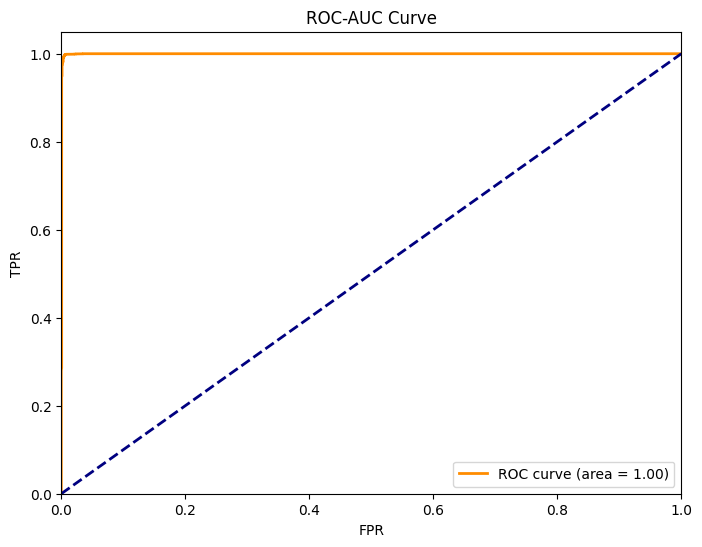

In [53]:
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [52]:
print(f'Precision: {precision_score(labels, [1 if i >= 0.5 else 0 for i in predictions])}')
print(f'Recall: {recall_score(labels, [1 if i >= 0.5 else 0 for i in predictions])}')

Precision: 0.9967679379444085
Recall: 0.9987046632124352


Классификатор ведёт себя как идеальный. Казалось бы, модель очень точно предсказывает, есть ли в тексте ответ на заданный вопрос. Однако, обнадёживать себя в данном случае не стоит. Дело в том, как мы получали отрицательные примеры: мы к данному контексту приаттачили случайно сгенерированный из всей нашей выборки вопрос. Поэтому отрицательные примеры были очень примитивные. Модели не составляет труда понять условно что в тексте про космос нет рецепта фаршированного перца. То есть модель проверяет на самом деле не то, есть ли в тексте ответ на данный вопрос, а то, соответствует ли вопрос теме текста. Это можно понять, например, на этих примерах:

In [61]:
question5 = 'Сколько ног у Муму?'

tokens = tokenizer(question5, context, return_tensors='pt')

answer = get_answer(tokens)
answer[0], answer[1].item()

('В господский дом Муму не ходила и', 0.9999436140060425)

In [62]:
question6 = 'Что Герасим ел на завтрак?'

tokens = tokenizer(question6, context, return_tensors='pt')

answer = get_answer(tokens)
answer[0], answer[1].item()

('.. Так прошел еще год. Герасим продолжал свои', 0.9996675252914429)

Надо отметить сильную уверенность модели в том что данные ответы в тексте присутствуют

В качестве предобученной модели я использовал ruBert, ибо считается что Bert-like модели хороши в задаче понимания текста. У этой модели есть ограничения на количество входных токенов - максимум 512. Я попытался, тем не менее, научить её справляться с большими текстами. Для этого я решил разбивать большие тексты на части. Однако, если ответ находится на стыке этих частей, это может повлечь за собой некорректный результат. Поэтому я прохожусь по тексту окном размера 512(с учётом длины вопроса) и шагом 256, а не 512, чтобы весь текст обрабатывался корректно. Но что если модель найдёт ответы в нескольких частях текста - какой лучше выбрать? Интуитивно, выход классификатора наличия ответа в тексте можно интерпретировать как уверенность модели в своём ответе. Тогда я ещё не додумался что этот классификатор будет работать не совсем так как я задумывал, но в итоге эмпирически оказалось что такой подход действительно даёт относительно удобоваримые результаты. Для примера попробуем обработать большой текст

In [91]:
def get_answer_2(new_data):
    context_tokens = new_data['input_ids'][:, new_data['token_type_ids'].bool().squeeze()]
    question_tokens = new_data['input_ids'][:, ~new_data['token_type_ids'].bool().squeeze()]
    len_seq = 512 - len(question_tokens[0])

    cur_answer = 'Ответа на этот вопрос в тексте не нашлось'
    cur_has_answer = torch.tensor([0])
    answers = [('Ответа на этот вопрос в тексте не нашлось', 0)]

    if len(context_tokens[0]) > len_seq:
        for i in range((len(context_tokens[0]) // (len_seq // 2) - 1) * 2):
            querry = torch.cat((question_tokens, context_tokens[:, i*(len_seq // 2):i*(len_seq // 2) + len_seq]), dim=1)

            with torch.no_grad():
                start_logits, end_logits, has_answer = model(input_ids=querry, attention_mask=torch.ones_like(querry))

            if has_answer >= 0.5:
                start_index = torch.argmax(start_logits, dim=-1).item()
                end_index = torch.argmax(end_logits, dim=-1).item()


                answer_tokens = querry[0][start_index:end_index + 1]
                answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                cur_answer = answer
            answers.append((cur_answer, has_answer.item()))



            if i*(len_seq // 2) + len_seq >= len(context_tokens[0]):
                break

        cur_answer, cur_has_answer = max(answers, key=lambda x: x[1])

    else:
        start_logits, end_logits, has_answer = model(new_data['input_ids'], new_data['attention_mask'])

        if has_answer >= 0.5:
            start_index = torch.argmax(start_logits, dim=-1).item()
            end_index = torch.argmax(end_logits, dim=-1).item()

            answer_tokens = new_data['input_ids'][0][start_index:end_index + 1]
            answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
            cur_answer = answer
        cur_has_answer = has_answer

    return answers, cur_answer

In [78]:
context3 = '''Старинный двухэтажный дом кремового цвета помещался на бульварном кольце в глубине чахлого сада, отделенного от тротуара кольца резною чугунною решеткой.
Небольшая площадка перед домом была заасфальтирована, и в зимнее время на ней возвышался сугроб с лопатой, а в летнее время она превращалась в великолепнейшее отделение
летнего ресторана под парусиновым тентом.
Дом назывался «домом Грибоедова» на том основании, что будто бы некогда им владела тетка писателя – Александра Сергеевича Грибоедова.
Ну владела или не владела – мы того не знаем. Помнится даже, что, кажется, никакой тетки-домовладелицы у Грибоедова не было... Однако дом так называли.
Более того, один московский врун рассказывал, что якобы вот во втором этаже, в круглом зале с колоннами, знаменитый писатель читал отрывки из «Горя от ума» этой самой тетке,
раскинувшейся на софе, а впрочем, черт его знает, может быть, и читал, не важно это!
А важно то, что в настоящее время владел этим домом тот самый МАССОЛИТ, во главе которого стоял несчастный Михаил Александрович Берлиоз до своего появления на Патриарших прудах.
С легкой руки членов МАССОЛИТа никто не называл дом «домом Грибоедова», а все говорили просто – «Грибоедов»: «Я вчера два часа протолкался у Грибоедова»,
– «Ну и как?» – «В Ялту на месяц добился». – «Молодец!». Или: «Пойди к Берлиозу, он сегодня от четырех до пяти принимает в Грибоедове...» И так далее.
МАССОЛИТ разместился в Грибоедове так, что лучше и уютнее не придумать. Всякий, входящий в Грибоедова, прежде всего знакомился невольно с извещениями разных спортивных
кружков и с групповыми, а также индивидуальными фотографиями членов МАССОЛИТа, которыми (фотографиями) были увешаны стены лестницы, ведущей во второй этаж.
На дверях первой же комнаты в этом верхнем этаже виднелась крупная надпись «Рыбно-дачная секция», и тут же был изображен карась, попавшийся на уду.
На дверях комнаты N 2 было написано что-то не совсем понятное: «Однодневная творческая путевка. Обращаться к М. В. Подложной».
Следующая дверь несла на себе краткую, но уже вовсе непонятную надпись: «Перелыгино». Потом у случайного посетителя Грибоедова начинали разбегаться глаза от надписей,
пестревших на ореховых теткиных дверях: «Запись в очередь на бумагу у Поклевкиной», «Касса», «Личные расчеты скетчистов»...
Прорезав длиннейшую очередь, начинавшуюся уже внизу в швейцарской, можно было видеть надпись на двери, в которую ежесекундно ломился народ: «Квартирный вопрос».
За квартирным вопросом открывался роскошный плакат, на котором изображена была скала, а по гребню ее ехал всадник в бурке и с винтовкой за плечами.
Пониже – пальмы и балкон, на балконе – сидящий молодой человек с хохолком, глядящий куда-то ввысь очень-очень бойкими глазами и держащий в руке самопишущее перо.
Подпись: «Полнообъемные творческие отпуска от двух недель (рассказ-новелла) до одного года (роман, трилогия). Ялта, Суук-Су, Боровое, Цихидзири, Махинджаури,
Ленинград (Зимний дворец)». У этой двери также была очередь, но не чрезмерная, человек в полтораста.
Далее следовали, повинуясь прихотливым изгибам, подъемам и спускам Грибоедовского дома, – «Правление МАССОЛИТа», «Кассы N 2, 3, 4, 5», «Редакционная коллегия»,
«Председатель МАССОЛИТа», «Бильярдная», различные подсобные учреждения, наконец, тот самый зал с колоннадой, где тетка наслаждалась комедией гениального племянника.
Всякий посетитель, если он, конечно, был не вовсе тупицей, попав в Грибоедова, сразу же соображал, насколько хорошо живется счастливцам – членам МАССОЛИТа,
и черная зависть начинала немедленно терзать его. И немедленно же он обращал к небу горькие укоризны за то, что оно не наградило его при рождении литературным
талантом, без чего, естественно, нечего было и мечтать овладеть членским МАССОЛИТским билетом, коричневым, пахнущим дорогой кожей, с золотой широкой каймой, –
известным всей Москве билетом.
Кто скажет что-нибудь в защиту зависти? Это чувство дрянной категории, но все же надо войти и в положение посетителя.
Ведь то, что он видел в верхнем этаже, было не все и далеко еще не все. Весь нижний этаж теткиного дома был занят рестораном, и каким рестораном!
По справедливости он считался самым лучшим в Москве. И не только потому, что размещался он в двух больших залах со сводчатыми потолками,
расписанными лиловыми лошадьми с ассирийскими гривами, не только потому, что на каждом столике помещалась лампа, накрытая шалью, не только потому, что туда
не мог проникнуть первый попавшийся человек с улицы, а еще и потому, что качеством своей провизии Грибоедов бил любой ресторан в Москве, как хотел, и что эту
провизию отпускали по самой сходной, отнюдь не обременительной цене.'''

In [92]:
question3_1 = 'Чем пахнет членский МАССОЛИТский билет?'

tokens = tokenizer(question3_1, context3, return_tensors='pt')

answers = get_answer_2(tokens)

print(f'Ответы, которые модель нашла в тексте, вместе с уверенностями: {answers[0]}')
print(f'Окончательный ответ модели: {answers[1]}')

Ответы, которые модель нашла в тексте, вместе с уверенностями: [('Ответа на этот вопрос в тексте не нашлось', 0), ('индивидуальными фотографиями', 0.9968128800392151), ('стены лестницы', 0.9985554814338684), ('коричневым, пахнущим дорогой кожей, с золотой широкой каймой', 0.9998750686645508), ('коричневым, пахнущим дорогой кожей', 0.9999831914901733)]
Окончательный ответ модели: коричневым, пахнущим дорогой кожей


In [93]:
question3_2 = 'Чем был занят весь нижний этаж теткиного дома?'

tokens = tokenizer(question3_2, context3, return_tensors='pt')

answers = get_answer_2(tokens)

print(f'Ответы, которые модель нашла в тексте, вместе с уверенностями: {answers[0]}')
print(f'Окончательный ответ модели: {answers[1]}')

Ответы, которые модель нашла в тексте, вместе с уверенностями: [('Ответа на этот вопрос в тексте не нашлось', 0), ('стены лестницы, ведущей во второй этаж', 0.9997724890708923), ('В Ялту на месяц добился ». – « Молодец! ». Или : « Пойди к Берлиозу, он сегодня от четырех до пяти принимает в Грибоедове... » И так далее. МАССОЛИТ разместился в Грибоедове так, что лучше и уютнее не придумать. Всякий, входящий в Грибоедова, прежде всего знакомился невольно с извещениями разных спортивных кружков и с групповыми, а также индивидуальными фотографиями членов МАССОЛИТа, которыми ( фотографиями ) были увешаны стены лестницы', 0.9798363447189331), ('». У этой двери', 0.9999157190322876), ('все. Весь нижний этаж теткиного дома был занят рестораном', 0.9999316930770874)]
Окончательный ответ модели: все. Весь нижний этаж теткиного дома был занят рестораном


Видим, что модель способна понимать что происходит в конце большого текста, хотя в ответе есть лишние слова. Однако, если интерпретировать выход классификатора как уверенность модели, получается что модель сильно уверена во всех ответах, но в правильном уверена лишь немного больше. Поэтому при чуть менее очевидных формулировках результат работы модели в больших текстах будет неустойчив

Теперь посчитаем precision и recall нашей qa-модели

In [102]:
precision = sum(precisions) / len(precisions)
recall = sum(recalls) / len(recalls)

print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')

Precision: 0.82
Recall: 0.85


Иными словами, в среднем, 82% токенов, предсказываемых моделью, оказываются правильными. В среднем моделью предсказывается 85% токенов правильного ответа. Чтобы выразить качество модели в одном числе, воспользуемся F-betta мерой. Учитывая, что в нашей задаче recall важнее чем precision(не так страшно если мы захватим несколько лишних токенов в ответе, важнее чтобы в выходе модели ответ содержался полностью), возьмём коэффициент betta = 1.5

In [101]:
betta = 1.5
f_score = (1 + betta**2) * precision * recall / (betta**2 * precision + recall)

print(f'F-score: {round(f_score, 2)}')

F-score: 0.84


Видно, что модели есть куда расти

Как можно сделать лучше?

1. Эта модель недообучена. Она обучалась 10 эпох, что недостаточно.
2. Нужно больше разнообразных данных, больше неочевидных формулировок вопросов в обучающей выборке. Потому что очень много вопросов в датасете задаются теми же словами, которыми про это написано в тексте, например:<br> Контекст: "...Первые упоминания о строении человеческого тела встречаются в Древнем Египте. В XXVII веке до н. э. египетский врач Имхотеп описал некоторые органы и их функции, в частности головной мозг, деятельность сердца, распространение крови по сосудам...."<br>
Вопросы: Где встречаются первые упоминания о строении человеческого тела?<br>
или Когда египетский врач Имхотеп впервые описал некоторые органы и их функции?<br>
Нужны вопросы которые не просто буквально повторяют то что написано в тексте, а как можно более перефразированные, чтобы модель больше училась понимать контекст, а не просто искать похожие слова в тексте.
3. Нужны также отрицательные примеры, чтобы если ответа в тексте не найдено, у модели была возможность не выдавать какой-то случайный пассаж, а вывести в качестве вывода что ответа в тексте нет.
4. Необходимо разработать более устойчивый метод обработки длинных текстов или доработать существующий.